<a href="https://colab.research.google.com/github/mariaimr/Esp-Analitica-y-Ciencia-de-Datos/blob/main/Solucion_Taller_An%C3%A1lisis_exploratorio_de_un_dataset_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Autores**


*   Camilo Llerena Riascos
*   Maria Isabel Martínez Rendón
*   Santiago Felipe Rosales Guerrero






In [45]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/UDEA-Esp-Analitica-y-Ciencia-de-Datos/EACD-01-FUNDAMENTOS/master/init.py
import init; init.init(force_download=False); 

# Precios de Casas

El objetivo de este taller es realizar un análisis exploratorio de un dataset. El dataset no llega limpio, el proceso de limpieza se encuentra implementado. Después de este proceso de limpieza se debe llevar a cabo el análisis exploratorio.

In [46]:
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Entendiendo y limpiando el dataset

La descripcion de cada variable puede verse ejecutando la siguiente celda

In [47]:
!cat local/data/houseprices_description.txt

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

Ahora carguemos los datos y hagamos una breve exploración

In [48]:
df = pd.read_csv("local/data/houseprices.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Podemos ver que hay una gran cantidad de valores nulos en algunas de las variables. Alguien, algo despistado, podría sugerir simplemente eliminar esas variables; sin embargo, la descripción de las variables que observamos anteriormente, nos permite entender la razón de ser de estos valores nulos y tratarlos de una manera inteligente. Por ejemplo, consideremos la variable `PoolQC` la cual nos muestra únicamente 7 valores no nulos de los 1460 registros que tenemos en total. Su descripción dice:

```
PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool

```

Esta variable hace referencia a la calidad de la piscina en la casa y vemos que `NA` significa que no tiene piscina, lo cual posiblemente tiene mucho impacto en el precio de una casa (pregúntese, ¿estaría dispuesto a pagar más por una casa que tenga piscina?). Además, vemos que existe la variable `PoolArea`, la cual almacena el area de la piscina en $ft^2$, la cual no tiene valores nulos. Dado esto, los valores nulos de la variable `PoolQC` deben corresponder a casos en los que la variable `PoolArea` es cero; validemos esto.

In [50]:
num_total_nulls = df["PoolQC"].isna().sum()
num_nulls_when_poolarea_is_zero = df[df["PoolArea"] == 0]["PoolQC"].isna().sum()
assert num_nulls_when_poolarea_is_zero == num_total_nulls

In [51]:
num_nulls_when_poolarea_is_not_zero = df[df["PoolArea"] != 0]["PoolQC"].isna().sum()
assert num_nulls_when_poolarea_is_not_zero == 0

Concluimos que se cumple que todos los valores nulos de la variable `PoolQC` corresponden a casos en los que no hay piscina; por lo tanto, vamos a reemplzar los valores nulos por otro valor que podamos usar en nuestros modelos.

In [52]:
df["PoolQC"] = df["PoolQC"].fillna("NP")

Esta misma lógica debemos usarla a la hora de tratar el resto de las variables con valores nulos de este dataset. Escribiremos algún razonamiento addiconal únicamente cuando haga falta

In [53]:
num_total_nulls = df["MiscFeature"].isna().sum()
num_nulls_when_miscval_is_zero = df[df["MiscVal"] == 0]["MiscFeature"].isna().sum()
num_nulls_when_miscval_is_not_zero = df[df["MiscVal"] != 0]["MiscFeature"].isna().sum()
assert num_nulls_when_miscval_is_zero == num_total_nulls
assert num_nulls_when_miscval_is_not_zero == 0
df["MiscFeature"] = df["MiscFeature"].fillna("No MF")

In [54]:
num_total_nulls = df["FireplaceQu"].isna().sum()
num_nulls_when_fireplaces_is_zero = df[df["Fireplaces"] == 0]["FireplaceQu"].isna().sum()
num_nulls_when_fireplaces_is_not_zero = df[df["Fireplaces"] != 0]["FireplaceQu"].isna().sum()
assert num_nulls_when_fireplaces_is_zero == num_total_nulls
assert num_nulls_when_fireplaces_is_not_zero == 0
df["FireplaceQu"] = df["FireplaceQu"].fillna("No FP")

In [55]:
num_area_zeros = (df["GarageArea"] == 0).sum()
num_cars_zeros = (df["GarageCars"] == 0).sum()
num_both_zeros = ((df["GarageArea"] == 0) & (df["GarageCars"] == 0.0)).sum()
assert num_both_zeros == num_area_zeros == num_cars_zeros
for colname in ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]:
    num_total_nulls = df[colname].isna().sum()
    num_nulls_when_area_and_cars_capacity_is_zero = df[(df["GarageArea"] == 0.0) & (df["GarageCars"] == 0.0)][colname].isna().sum()
    num_nulls_when_area_and_cars_capacity_is_not_zero = df[(df["GarageArea"] != 0.0) & (df["GarageCars"] != 0.0)][colname].isna().sum()
    assert num_total_nulls == num_nulls_when_area_and_cars_capacity_is_zero
    assert num_nulls_when_area_and_cars_capacity_is_not_zero == 0
    df[colname] = df[colname].fillna("No Ga")

Para la variable `GarageYrBlt` debemos ser más cuidadosos, ya que son números y no strings. Esta variable nos dice el año en que fue construido el garaje y, según lo visto con otras variables relacionadas al garage, los valores nulos corresponden a casos en los que no hay garage. En este caso, vamos a imputar esa variable con un año posterior a la fecha de venta. Esta aproximación podría no funcionar muy bien con modelos lineales, o cuando escalamos los datos, pero no se me ocurre otra!

In [56]:
num_total_nulls = df["GarageYrBlt"].isna().sum()
num_nulls_when_area_and_cars_is_zero = df[(df["GarageArea"] == 0.0) & (df["GarageCars"] == 0.0)]["GarageYrBlt"].isna().sum()
num_nulls_when_area_and_cars_is_not_zero = df[(df["GarageArea"] != 0.0) & (df["GarageCars"] != 0.0)]["GarageYrBlt"].isna().sum()
assert num_nulls_when_area_and_cars_is_zero == num_total_nulls
assert num_nulls_when_area_and_cars_is_not_zero == 0
df["GarageYrBlt"].where(~df["GarageYrBlt"].isna(), other=df["YrSold"] + 1, inplace=True)

`LotFrontage: Linear feet of street connected to property)`

Valores nulos en esta variable podrían ser ocasionados porque sencillamente no hay conexión de la calle a la propiedad, es decir, que esa longitud medida por esta variable es igual a 0. Podemos asumir que este es el caso únicamente si no hay otro 0 en los valores que ha tomado esta variable, de otra manera ¿por qué algunos tendrían 0 y otros nulos?

In [57]:
assert (df["LotFrontage"] == 0).sum() == 0
df["LotFrontage"].fillna(0, inplace=True)

In [58]:
df["Alley"].fillna("NA", inplace=True)
df["Fence"].fillna("NF", inplace=True)

```
MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone
	
MasVnrArea: Masonry veneer area in square feet
```

Una posibilidad es que los valores nulos de `MasVnrType` y `MasVnrArea` correspondan a casos en los que no hay "Masonry veneer" (chapa de albañilería). Esto sería en los casos en que la variable `MasVnrArea` sea 0, esto lo validaremos de la misma manera en que validamos con la variable `LotFrontage`.

In [59]:
assert (df["MasVnrArea"] == 0).sum() == df["MasVnrType"].isnull().sum()

AssertionError: ignored

Acá la situación es diferente, el error anterior nos dice que los casos para los cuales no tenemos área son distintos de los que el tipo es nulo, entonces nos toca inspeccionar más en detalle. Sabemos que hay 8 valores nulos en cada una de las dos variables, miremos si corresponden a los mismos registros:

In [60]:
np.logical_and(df["MasVnrType"].isnull().values, df["MasVnrArea"].isnull().values).sum()

8

En efecto, dado que hay 8 registros para los cuales las dos variables tienen valores nulos, podemos decir que son nulos en ambas partes. A falta de información, vamos a decidir eliminar esos registros por completo, no debe ser muy grave, pues apenas son 8 filas en todo el dataset.

In [61]:
df = df.dropna(subset=["MasVnrType", "MasVnrArea"])

Ahora miremos los valores de cada una

In [62]:
df["MasVnrType"].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [63]:
df["MasVnrArea"].value_counts()

0.0      861
180.0      8
72.0       8
108.0      8
120.0      7
        ... 
562.0      1
89.0       1
921.0      1
762.0      1
119.0      1
Name: MasVnrArea, Length: 327, dtype: int64

Acá podemos observar lo siguiente:
- Hay 864 registros con `MasVnrType="None"`
- Hay 861 registros con `MasVnrArea=0`

Eso quiere decir que hay algunos registros que deberían tener un área de 0 y no es así. Vamos a mirar en detalle cuáles son:

In [64]:
df[(df["MasVnrType"] == "None") & (df["MasVnrArea"] != 0.0)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
624,625,60,RL,80.0,10400,Pave,NA,Reg,Lvl,AllPub,...,0,NP,NF,No MF,0,11,2006,WD,Normal,165150
773,774,20,RL,70.0,10150,Pave,NA,Reg,Lvl,AllPub,...,0,NP,NF,No MF,0,7,2007,COD,Normal,114500
1230,1231,90,RL,0.0,18890,Pave,NA,IR1,Lvl,AllPub,...,0,NP,NF,Gar2,8300,8,2007,WD,Normal,190000
1300,1301,60,RL,0.0,10762,Pave,NA,IR1,Lvl,AllPub,...,0,NP,NF,No MF,0,5,2009,WD,Normal,225000
1334,1335,160,RM,24.0,2368,Pave,NA,Reg,Lvl,AllPub,...,0,NP,NF,No MF,0,5,2009,WD,Normal,125000


**Francamente** yo no soy un experto en casas, por lo que no tengo forma de deducir a qué se debe esa incoherencia en los datos. Por lo anterior, simplemente voy a eliminar esas filas, ya que tengo dudas de la veracidad de esos datos.

In [65]:
df = df[~((df["MasVnrType"] == "None") & (df["MasVnrArea"] != 0.0))]

La variable `Electrical` tampoco nos ofrece una forma de recuperar esos valores nulos, por lo que también vamos a eliminar ese registro. Nótese que otra opción podría ser reemplazarlo con el valor más común en la misma variable, dado que esta es categórica. 

In [66]:
df.dropna(subset=["Electrical"], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1446 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1446 non-null   int64  
 1   MSSubClass     1446 non-null   int64  
 2   MSZoning       1446 non-null   object 
 3   LotFrontage    1446 non-null   float64
 4   LotArea        1446 non-null   int64  
 5   Street         1446 non-null   object 
 6   Alley          1446 non-null   object 
 7   LotShape       1446 non-null   object 
 8   LandContour    1446 non-null   object 
 9   Utilities      1446 non-null   object 
 10  LotConfig      1446 non-null   object 
 11  LandSlope      1446 non-null   object 
 12  Neighborhood   1446 non-null   object 
 13  Condition1     1446 non-null   object 
 14  Condition2     1446 non-null   object 
 15  BldgType       1446 non-null   object 
 16  HouseStyle     1446 non-null   object 
 17  OverallQual    1446 non-null   int64  
 18  OverallC

Ahora miremos las variables relacionadas con el basement:

```

BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
	
BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
	
BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
		
BsmtFinSF1: Type 1 finished square feet

BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

BsmtFinSF2: Type 2 finished square feet

BsmtUnfSF: Unfinished square feet of basement area

TotalBsmtSF: Total square feet of basement area

```

Dado que los valores nulos en varias de estas variables corresponden a `No Basement`, ahora miremos si los registros nulos en algunas corresponden a los registros nulos en todas. Primero, dado que ya hemos eliminado varios registros, vamos a ver cuántos valores nulos hay en esas variables.

In [68]:
colnames = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
    "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF"]
for c in colnames:
    print(f"{c} has {df[c].isnull().sum()} null values")

BsmtQual has 37 null values
BsmtCond has 37 null values
BsmtExposure has 38 null values
BsmtFinType1 has 37 null values
BsmtFinSF1 has 0 null values
BsmtFinType2 has 38 null values
BsmtFinSF2 has 0 null values
BsmtUnfSF has 0 null values
TotalBsmtSF has 0 null values


In [69]:
df["TotalBsmtSF"].value_counts()

0       37
864     35
672     17
912     14
1040    14
        ..
1581     1
707      1
611      1
1452     1
1542     1
Name: TotalBsmtSF, Length: 716, dtype: int64

Acá vemos que algunas tienen más variables nulas que otras, lo cual es confuso porque en cualquier caso los valores nulos deberían significar que no hay basement. En este caso vamos a reemplazar los valores en los que los valores nulos sean en todas las variables no numéricas pero los que sobren los eliminaremos.

In [70]:
colnames = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]
cond = ~(df["BsmtQual"].isna() & df["BsmtCond"].isna() & df["BsmtExposure"].isna() & df["BsmtFinType1"].isna() & df["BsmtFinType2"].isna())
for c in colnames:
    df[c].where(cond, other="NB", inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [71]:
df.dropna(inplace=True)
print(f"Number of null values {df.isna().sum().sum()} in a dataframe of shape {df.shape}")

Number of null values 0 in a dataframe of shape (1444, 81)


## Análisis exploratorio de datos

En esta sección se dejarán preguntas que deben ser respondidas utilizando los datos.

**¿Qué tan viejas son las casas?**

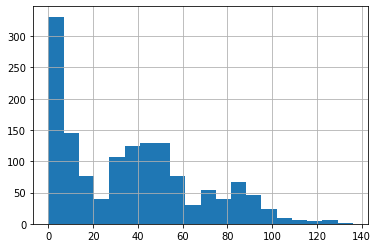

In [72]:
df["HouseAge"] = df["YrSold"] - df["YearBuilt"]
df["HouseAge"].hist(bins=20)

**¿Cómo se relaciona el precio con la edad de la casa?**

Para está pregunta, nos apoyamos en las variables **SalePrice** y **HouseAge** la cual se calculó anteriormente restando el año de venta (**YrSold**) menos el año de construcción (**YearBuilt**).

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


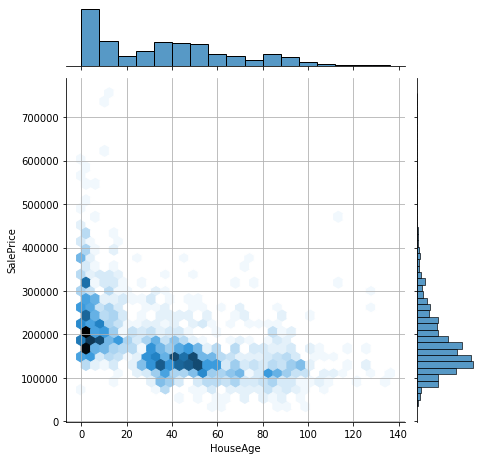

In [73]:
import seaborn as sns
sns.jointplot(df["HouseAge"], df["SalePrice"], kind='hex',height=6.5)
plt.grid()

La grafica nos permite observar en el eje horizontal la edad de la casa **HouseAge** y el eje vertical los precios **SalePrice**. De esto se concluye que el precio de las casas mas costosas son las que estan entre 10 y 20 años, las más econonomicas son las que tienen entre 60 y 100 años. Se vendieron más casas entre de precios cercanos a 200.000 con una edad menor a 5 años. 


**¿Cuál es el barrio más pobre?**

Para definir el barrio más pobre decidimos integrar tres variables del conjutno de datos: **OverallQual**, **OverallCond**, y **SalePrice**. La primera definición fue integrar las dos variables que calificaban las condiciones de la vivienda, siendo esta un indicador proporcional a los ingresos. En primera instancia generamos una nueva variable que contiene el promedio de la calificación dato a dato de **OverallQual** y **OverallCond**

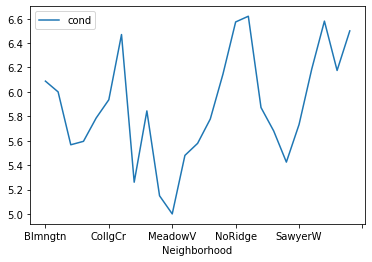

In [74]:
df["cond"] = (df["OverallQual"] + df["OverallCond"])/2
mean_cond = df.groupby(["Neighborhood"]).agg({"cond":"mean"})
mean_cond.plot()

Posteriormente tomamos la variable **SalePrice** como un indicador económico relevante en la definición del nivel de pobreza de una barrio, entre más barata la casa, mayor el nivel de pobreza

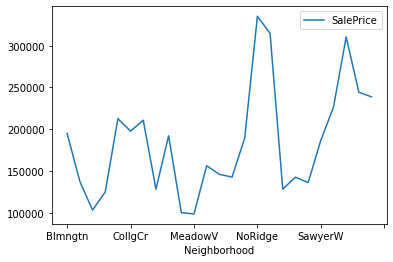

In [75]:
mean_n = pd.pivot_table(df,index=["Neighborhood"],aggfunc={"SalePrice":np.mean})
mean_n.plot()

Para darle mayor argumentación a la definición del barrio más pobre decidimos tomar las condiciones de la vivienda (**cond**) y el precio de la misma (**SalePrice**) como un indicador agregado y diciente sobre el nivel de pobreza. En este sentido realizamos la integración a través de una multiplicación que equivale a una ponderación de las dos variables

In [76]:
df["Metrica"] = (df["cond"] * df["SalePrice"])

En la nueva tabla creada, las tres varibales se verían así (ejemplo en 5 lineas):

In [77]:
sample = df[["SalePrice","cond","Metrica"]].sample(5)
sample

,SalePrice,cond,Metrica
1434,160000,5.0,800000.0
1360,189000,5.5,1039500.0
203,149000,5.5,819500.0
744,180000,6.5,1170000.0
1389,131000,6.0,786000.0


Finalmente, creamos una nueva agrupación por barrio para definir, de acuerdo al valor más bajo de la variable **Metrica**, cual es el barrio más pobre

In [78]:
poverty = df.groupby(["Neighborhood"]).agg({"cond":"mean", "SalePrice":"mean","Metrica":"mean"})
m = poverty["Metrica"].reset_index(name="Metrica")
m[m["Metrica"] == m["Metrica"].min()]

,Neighborhood,Metrica
10,MeadowV,498273.529412


En conclusión el barrio más pobre es: **MeadowV**

**¿Cuál es el barrio más cercano a vías férreas?**

Para este punto se utilizaron los parametros de **Condition1** y **Condition2**, y los valores "RRNn", "RRAn", "RRNe" y "RRAe" los cuales indican la proximidad a las vias ferreas. Se crea la columna Size para hacer referencia a la cantidad de casas por barrio y se ordena de mayor a menor.

In [79]:
df2=df[(df["Condition1"] == "RRNn") | (df["Condition1"] == "RRAn") | (df["Condition1"] == "RRNe")| (df["Condition1"] == "RRAe") |(df["Condition2"] == "RRNn") | (df["Condition2"] == "RRAn") | (df["Condition2"] == "RRNe")| (df["Condition2"] == "RRAe")]["Neighborhood"].reset_index(name='Neighborhood')
bar_fer = df2.groupby("Neighborhood").size().reset_index(name='Size')
bar_fer.sort_values('Size', ascending= False)

,Neighborhood,Size
0,BrkSide,9
1,Gilbert,9
3,NWAmes,7
5,Sawyer,6
6,SawyerW,6
7,Somerst,6
2,IDOTRR,2
4,OldTown,2


Como se observa en la parte superior de la tabla se encuentras el/los barrio(s) más cercano(s) a las vías férreas, en este caso lo cumplen dos barrios.

In [80]:
bar_fer[bar_fer['Size']==bar_fer['Size'].max()]

,Neighborhood,Size
0,BrkSide,9
1,Gilbert,9


In [81]:
maximo=bar_fer['Size'].max()
resultado=bar_fer[bar_fer['Size']==bar_fer['Size'].max()]
print(f"el/Los barrio(s) más cercano(s) a las vias ferreas son:")
for i in range(resultado["Size"].count()):
  print(f"{resultado.iat[i,0]}")

el/Los barrio(s) más cercano(s) a las vias ferreas son:
BrkSide
Gilbert


**¿Cuál es la cobertura más común en las casas que se encuentran el el top 10% en precio?**

Para calcular el top 10% en precio, decidimos usar el percentil 90 de los datos correspondientes a la columna **SalePrice**. Para obtener asi, el 10% de casas cuyo precio de venta es mayor.

In [82]:
percent_10 = df.SalePrice.quantile(0.9)
print(percent_10)


277850.0


Una vez obtenido el valor del percentil 90, que para los datos de este ejercicio arroja un valor de: **277850.0**, seleccionamos las columnas **Exterior1st**, **Exterior2nd**; que tienen el detalle de la cobertura de los exteriores de las casas; y el valor comercial, identificado por la columna **SalePrice**.
Luego, sobre el dataFrame con las columnas que seleccionamos, filtramos las casas cuyo precio sea mayor al valor calculado por el percentil 90 y a su vez es ordenado de forma descendente por su precio.


In [83]:
df_cobertura = df[['Exterior1st','Exterior2nd','SalePrice']]

top_10_percent = df_cobertura[df['SalePrice'] > percent_10]
top_10_percent = top_10_percent.sort_values('SalePrice', ascending= False)

top_10_percent


,Exterior1st,Exterior2nd,SalePrice
691,HdBoard,HdBoard,755000
1182,Wd Sdng,ImStucc,745000
1169,HdBoard,HdBoard,625000
898,VinylSd,VinylSd,611657
803,VinylSd,VinylSd,582933
...,...,...,...
408,VinylSd,VinylSd,280000
451,Plywood,Plywood,280000
13,VinylSd,VinylSd,279500
1288,CemntBd,CmentBd,278000


Finalmente, realizamos el conteo de cada uno de los materiales de la cobertura tanto para el exterior 1, como el exterior 2 (para el caso de que haya mas de un exterior). Se organizan los materiales de mayor repetición a menor y se obtiene el material de cobertura más común para ambos exteriores. 


In [84]:
exterior_1st = top_10_percent.groupby('Exterior1st').size().reset_index(name='Size')
exterior_2nd = top_10_percent.groupby("Exterior2nd").size().reset_index(name='Size')

by_exterior_1st = exterior_1st.sort_values('Size', ascending= False)
print(f"la cobertura más común del exterior 1 es: {by_exterior_1st.head(1).iat[0,0]} con una cantidad de {by_exterior_1st.head(1).iat[0,1]} casas")

by_exterior_2nd = exterior_2nd.sort_values('Size', ascending= False)
print(f"la cobertura más común del exterior 2 es: {by_exterior_2nd.head(1).iat[0,0]} con una cantidad de {by_exterior_2nd.head(1).iat[0,1]} casas")

la cobertura más común del exterior 1 es: VinylSd con una cantidad de 85 casas
la cobertura más común del exterior 2 es: VinylSd con una cantidad de 83 casas


Se puede concluir que para ambos exteriores la cobertura más común en las casas es el Revestimiento de vinilo (**Vinyl Siding**)

**¿En qué barrio hay mayor desigualdad?**

Para definir el barrio con mayor desigualdad tomamos el valor de la desviación estandar en **SalePrice**, es decir, la medición de la distancia entre cada valor respecto su promedio. En este sentido, entre mayor sea la desviación, mayor el indice de desigualdad.

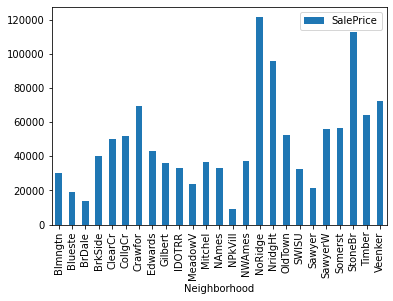

In [85]:
std_n = pd.pivot_table(df,index=["Neighborhood"],aggfunc={"SalePrice":np.std})
std_n.plot(kind="bar")
plt.show()

En conclusión el barrio con mayor desigualdad es: **NoRidge**

In [86]:
m = poverty["SalePrice"].reset_index(name="SalePrice")
m
m[m["SalePrice"] == m["SalePrice"].max()]

,Neighborhood,SalePrice
15,NoRidge,335295.317073


**¿En qué año hubo más movimiento del mercado inmobiliario?**

Para esta pregunta nos centramos en el parametro **YrSold**, ya que se entendió como movimiento del mercado inmobiliario a la cantidad de casas vendidas.

In [87]:
df["YrSold"].value_counts()

2009    334
2007    325
2006    311
2008    300
2010    174
Name: YrSold, dtype: int64

 La siguiente grafica nos permite observar la cantidad de casas vendidas por año.

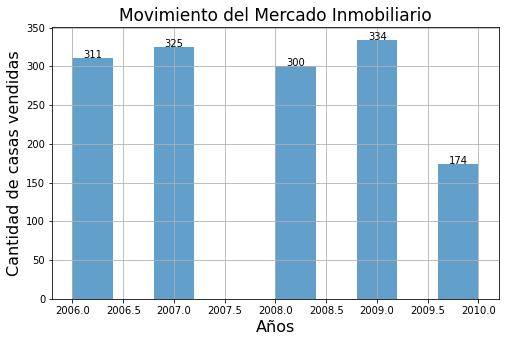

In [88]:
plt.figure(figsize=(8,5))
df["YrSold"].hist(histtype='barstacked',alpha=0.7,align="mid")
# Add labels to the plot
style = dict(size=10, color='black')
plt.text(2006.2,311,"311", ha='center', **style)
plt.text(2007, 325, "325", ha='center', **style)
plt.text(2008.2, 300, "300", ha='center', **style)
plt.text(2009.1, 334, "334", ha='right', **style)
plt.text(2009.8, 174, "174", ha='center', **style)
plt.xlabel("Años", size = 16,)
plt.ylabel("Cantidad de casas vendidas", size = 16)
plt.title("Movimiento del Mercado Inmobiliario", size=17)
None

In [89]:
res=df["YrSold"].value_counts().reset_index(name='Size')
res.sort_values('Size', ascending= False)
print(f"El año en el que hubo mayor movimiento del mercado inmobiliario fue: {res.iat[0,0]}")

El año en el que hubo mayor movimiento del mercado inmobiliario fue: 2009


**¿Cuáles son los 2 barrios con mayor industria cerca?**

Para obtener los barrios con mayor industria cerca, usaremos la columna **MSZoning** que nos indica la clasificación general de zonificación de la casa en venta.

Obtenemos un nuevo dataframe con la columna Neighborhood, filtrando por los registros cuya zona sea **I** (Industrial), agrupamos por Neighborhood y agregamos una nueva columna con la cantidad de casas por barrio que hay en la zona industrial.

In [90]:
df_industrial = df[df['MSZoning'] == 'I']['Neighborhood'].reset_index(name='Neighborhood')
industrial = df_industrial.groupby("Neighborhood").size().reset_index(name='Size')

industrial



,Neighborhood,Size


Basados en el resultado anterior, podemos ver que el filtro por zonas industriales no arroja ningun resultado. Para confirmar que no hay casas donde el barrio esté ubicado en una zona industrial, listaremos todos los tipos de zonificaciones y validaremos si hay al menos una casa en zonificación **I**

In [91]:
df.groupby("MSZoning").size().reset_index(name='Size')

,MSZoning,Size
0,C (all),10
1,FV,62
2,RH,16
3,RL,1139
4,RM,217


Con lo anterior, se confirma que no hay barrios con zonificación industrial en el dataset, por lo que se concluye que **no hay** barrios con industria cerca.

**¿Cuáles son los 2 barrios con mayor comercio cerca?**

Para obtener los barrios con mayor comercio cerca, nos estaremos apoyando de la columna **MSZoning** que nos indica la clasificación general de zonificación de la casa en venta.

Obtenemos un nuevo dataframe con la columna Neighborhood, filtrando por los registros cuya zona sea **C** (Commercial). Para el dataset del ejercicio no hay registros solo con el valor de C, *por lo que asumiremos que* **C** *es equivalente a* **C (all)**

Agrupamos el dataframe por Neighborhood y creamos una nueva columna con la cantidad de casas que pertenecen al barrio cercano al comercio.

In [92]:
df_commercio = df[df['MSZoning'] == 'C (all)']['Neighborhood'].reset_index(name='Neighborhood')
commercio = df_commercio.groupby("Neighborhood").size().reset_index(name='Size')

commercio

,Neighborhood,Size
0,IDOTRR,9
1,OldTown,1


Finalmente, ordenamos los barrios de mayor a menor cantidad de casas con comercio cerca y obtenemos los 2 mayores. 
*Para este ejercicio solo existen 2 barrios que cumplen el criterio de comercio cerca pero se agrega este paso por si el dataset cambiara en el futuro*

In [93]:
by_commercio = commercio.sort_values('Size', ascending= False).head(2)

print(f"Los 2 barrios con mayor comercio cerca son: {by_commercio.iat[0,0]} y {by_commercio.iat[1,0]}")

Los 2 barrios con mayor comercio cerca son: IDOTRR y OldTown


Se puede concluir que los barrios con mayor comercio cerca son: **Iowa DOT and Rail Road** y **Old Town**